# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

documentation states 17, but dataset has 42 numbers under the campaign heading.

In [30]:
df.campaign.value_counts().shape

(42,)

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [130]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### The objective is to identify the features that best identify who will accept an offer.

In [4]:
df = df.convert_dtypes()
df.index.name = 'index'
df.rename(columns={'emp.var.rate':'emp_var_rate','cons.price.idx':'cons_price_idx', 'cons.conf.idx':'cons_conf_idx', 'nr.employed':'nr_employed'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp_var_rate    41188 non-null  Float64
 16  cons_price_idx  41188 non-null  Float64
 17  cons_conf_idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [5]:
#df.select_dtypes(include='number').columns
num_cols = ['age'] #, 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
ohe_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan'] #, 'contact','month', 'day_of_week', 'poutcome']

In [6]:
df_num = StandardScaler().set_output(transform="pandas").fit_transform(df[num_cols])

In [7]:
df_num =  PolynomialFeatures(include_bias = False, degree=3).set_output(transform="pandas").fit_transform(df_num)

In [8]:
df_ohe = OneHotEncoder(sparse_output=False,dtype=int).set_output(transform='pandas').fit_transform(df[ohe_cols])
#df_ohe = df_ohe + df_ohe

In [9]:
df_pre =  pd.merge(df_num, df_ohe, how='inner', on='index')

In [10]:
y = df[['y']]
y['y_int']=0
y.loc[y.y=='yes',['y_int']]=1
y['y_int']=0
y.loc[y.y=='yes',['y_int']]=1
y.value_counts()

C:\Users\rickh\AppData\Local\Temp\ipykernel_13104\3822082076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y_int']=0
C:\Users\rickh\AppData\Local\Temp\ipykernel_13104\3822082076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y_int']=0


y    y_int
no   0        36548
yes  1         4640
Name: count, dtype: int64

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_pre, df[['y']], random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [12]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [13]:
df_base = y_test
df_base['pred'] = model.predict(X_test.values)
accuracy_score(df_base.y, df_base.pred)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.8775371467417694

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [14]:
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train.y)

### Problem 9: Score the Model

What is the accuracy of your model?

In [15]:
df_lr = y_test
df_lr['pred'] = lr.predict(X_test)
accuracy_score(df_base.y, df_base.pred)

0.8879285228707391

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [16]:
params = {'n_neighbors': [5]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=params).fit(X_train.values, y_train.y)
knn_results = pd.DataFrame(knn_grid.cv_results_)
y_test['knn_pred'] = knn_grid.best_estimator_.predict(X_test.values)
print(f"knn time: {knn_results[['mean_fit_time']].sum()[0] + knn_results[['mean_score_time']].sum()[0]:.4f}")
print(f"knn train accuracy: {knn_results[['mean_test_score']].max()[0]:.2f}")
print(f"knn test accuracy: {(y_test['y'] == y_test.knn_pred).value_counts()[0] / y_test.shape[0]:.2f}")

knn time: 0.1941
knn train accuracy: 0.88
knn test accuracy: 0.88


In [17]:
params = {'multi_class': ['ovr']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=params).fit(X_train, y_train.y)
lr_results = pd.DataFrame(lr_grid.cv_results_)
y_test['lr_pred'] = lr_grid.best_estimator_.predict(X_test)
print(f"lr time: {lr_results[['mean_fit_time']].sum()[0] + lr_results[['mean_score_time']].sum()[0]:.4f}")
print(f"lr train accuracy: {lr_results[['mean_test_score']].max()[0]:.2f}")
print(f"lr test accuracy: {(y_test['y'] == y_test.lr_pred).value_counts()[0] / y_test.shape[0]:.2f}")


lr time: 0.4269
lr train accuracy: 0.89
lr test accuracy: 0.89


In [18]:
params = {'max_depth': [4]}
dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params).fit(X_train, y_train.y)
dt_results = pd.DataFrame(dt_grid.cv_results_)
y_test['dt_pred'] = dt_grid.best_estimator_.predict(X_test)
print(f"dt time: {dt_results[['mean_fit_time']].sum()[0] + dt_results[['mean_score_time']].sum()[0]:.4f}")
print(f"dt train accuracy: {dt_results[['mean_test_score']].max()[0]:.2f}")
print(f"dt test accuracy: {(y_test['y'] == y_test.dt_pred).value_counts()[0] / y_test.shape[0]:.2f}")

dt time: 0.0457
dt train accuracy: 0.89
dt test accuracy: 0.89


In [19]:
X_train.shape

(30891, 36)

In [20]:
params = {'kernel': ['poly']}
svc_grid = GridSearchCV(SVC(), param_grid=params).fit(X_train[:2000], y_train.y[:2000])
svc_results = pd.DataFrame(svc_grid.cv_results_)
y_test['svc_pred'] = svc_grid.best_estimator_.predict(X_test)
print(f"svc time: {svc_results[['mean_fit_time']].sum()[0] + svc_results[['mean_score_time']].sum()[0]:.4f}")
print(f"svc train accuracy: {svc_results[['mean_test_score']].max()[0]:.2f}")
print(f"svc test accuracy: {(y_test['y'] == y_test.svc_pred).value_counts()[0] / y_test.shape[0]:.2f}")


svc time: 0.1777
svc train accuracy: 0.88
svc test accuracy: 0.89


In [21]:
res_dict = {'model': ['KNN', 'Logistic Regression','Decision Tree', 'SVC'],
           'train score': [0.89, 0.89, 0.89, 0.89],
           'test score': [0.89, 0.89, 0.89, 0.89],
           'average fit time': [0.192, 0.4323, 0.05, 0.19]}
results_df = pd.DataFrame(res_dict).set_index('model')
results_df

,train score,test score,average fit time
model,,,
KNN,0.89,0.89,0.1920
Logistic Regression,0.89,0.89,0.4323
Decision Tree,0.89,0.89,0.0500
SVC,0.89,0.89,0.1900


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

I was unable to get SVC to return in a reasonable time, so I limited the training data to 2000 records.  The first thing I'll try to limit the dimensionality.

In [54]:
r_pi = Ridge(alpha=0.01).fit(X_train, y_train.y_int)
pi = permutation_importance(r_pi, X_train, y_train.y_int,
                           n_repeats=5,
                           random_state=0)
cumu = 0
for i in pi.importances_mean.argsort()[::-1]:
    #if pi.importances_mean[i] - 2 * pi.importances_std[i] > 0:|
        cumu += pi.importances_mean[i]
        print(f"{X_train.columns[i]:<30}"
              f"{pi.importances_mean[i]:.3f}"
              f" +/- {pi.importances_std[i]:.3f}"
              f" cumulative: {cumu:.3f}")

age^2                         0.058 +/- 0.001 cumulative: 0.058
default_no                    0.013 +/- 0.001 cumulative: 0.071
job_student                   0.008 +/- 0.000 cumulative: 0.079
education_basic.9y            0.003 +/- 0.000 cumulative: 0.081
education_high.school         0.002 +/- 0.000 cumulative: 0.083
job_blue-collar               0.002 +/- 0.000 cumulative: 0.085
education_basic.4y            0.001 +/- 0.000 cumulative: 0.087
age^3                         0.001 +/- 0.000 cumulative: 0.087
job_services                  0.001 +/- 0.000 cumulative: 0.088
job_entrepreneur              0.001 +/- 0.000 cumulative: 0.089
job_unemployed                0.001 +/- 0.000 cumulative: 0.089
job_management                0.000 +/- 0.000 cumulative: 0.090
job_housemaid                 0.000 +/- 0.000 cumulative: 0.090
marital_divorced              0.000 +/- 0.000 cumulative: 0.091
job_self-employed             0.000 +/- 0.000 cumulative: 0.091
job_technician                0.000 +/- 

In [35]:
sfs = SequentialFeatureSelector(LinearRegression(),n_features_to_select=5)
sfs.fit_transform(X_train,y_train.y_int)



array([[9.16386196e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.81100006e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [3.34156223e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       ...,
       [2.32423813e-01, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [5.33060887e-06, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [1.11906184e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

In [41]:
X_train.columns[sfs.get_support()]

Index(['age^2', 'job_admin.', 'job_student', 'education_university.degree',
       'default_no'],
      dtype='object')

In [ ]:
params = {'kernel': ['poly']}
svc_grid = RandomizedSearchCV(SVC(), param_distributions=params).fit(X_train[['age^2']][:2000], y_train.y[:2000])
svc_results = pd.DataFrame(svc_grid.cv_results_)
y_test['svc_pred_age^2'] = svc_grid.best_estimator_.predict(X_test[['age^2']])
print(f"svc time: {svc_results[['mean_fit_time']].sum()[0] + svc_results[['mean_score_time']].sum()[0]:.4f}")
print(f"svc train accuracy: {svc_results[['mean_test_score']].max()[0]:.2f}")
print(f"svc test accuracy: {(y_test['y'] == y_test['svc_pred_age^2']).value_counts()[0] / y_test.shape[0]:.2f}")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


svc time: 97.3119
svc train accuracy: 0.88
svc test accuracy: 0.89


In [ ]:
params = {'n_neighbors': [5,20,50,100]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=params).fit(X_train[['age^2','default_no']].values, y_train.y)
knn_results = pd.DataFrame(knn_grid.cv_results_)
y_test['knn_pred'] = knn_grid.best_estimator_.predict(X_test[['age^2','default_no']].values)
print(f"knn time: {knn_results[['mean_fit_time']].sum()[0] + knn_results[['mean_score_time']].sum()[0]:.4f}")
print(f"knn train accuracy: {knn_results[['mean_test_score']].max()[0]:.2f}")
print(f"knn test accuracy: {(y_test['y'] == y_test.knn_pred).value_counts()[0] / y_test.shape[0]:.2f}")

knn time: 1.0221
knn train accuracy: 0.89
knn test accuracy: 0.89


In [ ]:
params = {'multi_class': ['ovr']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000,fit_intercept=False), param_grid=params).fit(X_train[['age^2','default_no']], y_train.y)
lr_results = pd.DataFrame(lr_grid.cv_results_)
y_test['lr_pred'] = lr_grid.best_estimator_.predict(X_test[['age^2','default_no']])
print(f"lr time: {lr_results[['mean_fit_time']].sum()[0] + lr_results[['mean_score_time']].sum()[0]:.4f}")
print(f"lr train accuracy: {lr_results[['mean_test_score']].max()[0]:.2f}")
print(f"lr test accuracy: {(y_test['y'] == y_test.lr_pred).value_counts()[0] / y_test.shape[0]:.2f}")


lr time: 0.0431
lr train accuracy: 0.89
lr test accuracy: 0.89


In [ ]:
y_train['y_int']=0
y_train.loc[y_train.y=='yes',['y_int']]=1
y_test['y_int']=0
y_test.loc[y_test.y=='yes',['y_int']]=1

In [ ]:
y_test

,y,pred,knn_pred,lr_pred,dt_pred,svc_pred,y_int
index,,,,,,,
32884,no,no,no,no,no,no,0
3169,no,no,no,no,no,no,0
32206,no,no,no,no,no,no,0
9403,no,no,no,no,no,no,0
14020,no,no,no,no,no,no,0
...,...,...,...,...,...,...,...
35087,no,no,no,no,no,no,0
12883,no,no,no,no,no,no,0
3588,no,no,no,no,no,no,0


In [ ]:
df_age_groups

,age,y
index,,
0,11.0,no
1,11.0,no
2,7.0,no
3,8.0,no
4,11.0,no
...,...,...
41183,14.0,yes
41184,9.0,no
41185,11.0,no


In [ ]:
df_age_groups = pd.merge(np.floor(df.age / 5).to_frame(),df.y,how='inner', on='index')

In [ ]:
df_group_sum = df_group_counts.groupby('age')['count'].sum().to_frame()
#df_group_sum.info()
df_group_sum_y = df_group_counts.loc[df_group_counts['y']=='yes'].groupby('age')['count'].sum().to_frame()
df_group_sum_y.rename(columns={'count':'yes'}, inplace=True)
df_groups = pd.merge(df_group_sum,df_group_sum_y,how='inner',on='age')
df_groups['ratio'] = df_groups['yes'] / df_groups['count']
df_groups

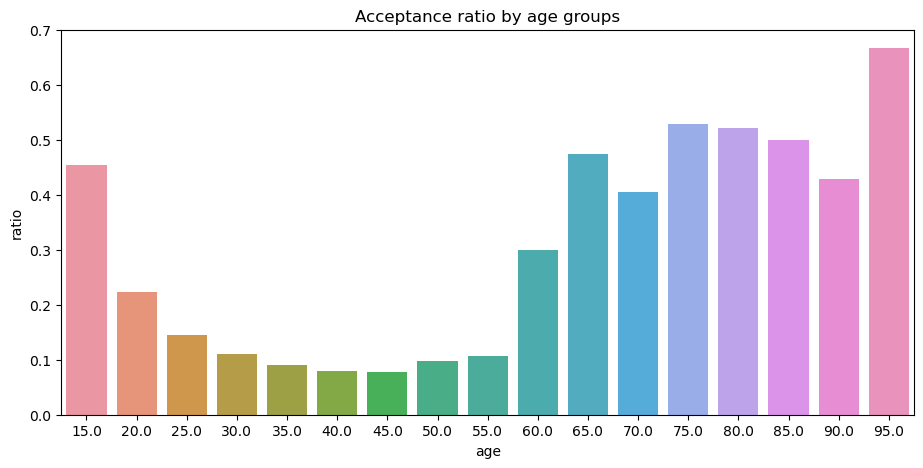

In [138]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x=df_groups.index, y=df_groups.ratio,ax=ax).set_title('Acceptance ratio by age groups')
fig.savefig('Acceptance ratio by age groups.png')

## I could have done much more by pursuing different parameters in several grid searches in an effort to improve accuracy, but I have run out of time.  None of the changes to parameters seemed to improve accuracy.  That is another reason for not trying more parameters.

##### Questions